<a href="https://colab.research.google.com/github/dotsnangles/from-keras-to-pytorch/blob/main/pneumonia_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터를 다운로드합니다.
- 캐글에 계정을 생성한 후 kaggle.json을 생성하여 아래의 코드를 순서대로 실행합니다.

In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dotsnangles","key":"22f5e94d3d4ae93abb4d71525709803c"}'}

In [ ]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:58<00:00, 42.3MB/s]
100% 2.29G/2.29G [00:58<00:00, 41.9MB/s]


In [ ]:
!mkdir -p /content/input/chest-xray-pneumonia
!unzip -q /content/chest-xray-pneumonia.zip -d /content/input/chest-xray-pneumonia

# 폐렴이란 무엇인가요?
- 폐렴은 폐포라고 알려진 작은 공기주머니에 주로 영향을 미치는 폐의 염증 상태입니다.증상은 일반적으로 습성적이거나나 건조한 기침, 가슴 통증, 발열, 호흡 곤란 등의 조합을 포함하며, 상태의 심각도는 가변적입니다. 
- 폐렴은 일반적으로 바이러스나 박테리아에 감염되어 발생하며, 다른 미생물, 특정 약물 또는 자가면역질환과 같은 조건에 의해 발생하는 경우는 드물다고 알려져 있습니다. 
- 관련 위험 인자로는 낭포성 섬유증, 만성 폐쇄성 폐질환(COPD), 천식, 당뇨병, 심부전, 흡연 이력, 뇌졸중과 같은 기침 능력 저하, 면역 체계 약화 등이 있으며, 진단은 보통 증상과 신체 검사를 기반으로 합니다. 흉부 엑스레이, 혈액 검사, 가래 배양 등이 진단 확인에 도움이 될 수 있습니다. 
- 폐렴은 지역사회 또는 병원에서 획득한 폐렴이나 의료 관련 폐렴과 같이 감염된 위치에 따라 분류될 수도 있습니다.
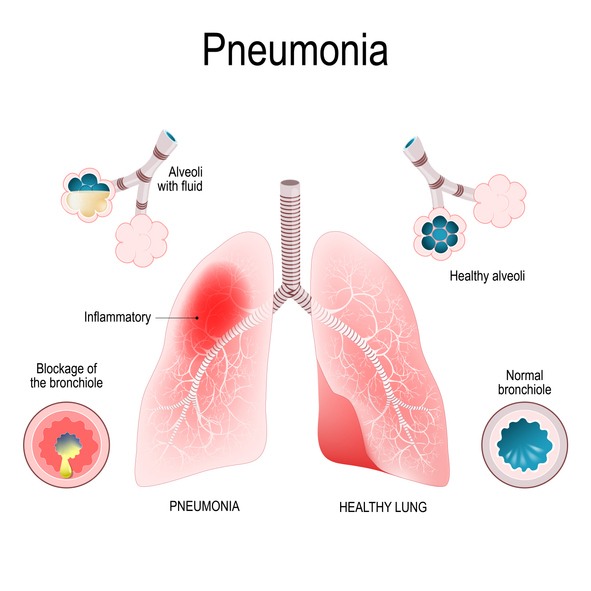

# 필요한 라이브러리들을 import 해줍니다.

In [ ]:
import random
import time
import os

import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 폐렴 데이터 세트

- 데이터 세트는 3개의 폴더(Train, test, val)로 구성되며 각 영상 범주(Pneumonia/Normal)에 대한 하위 폴더가 포함됩니다. 5,863개의 X선 영상(JPEG)과 2개의 범주(폐렴/정상)가 있습니다.
- 흉부 X선 영상(앞-뒤)은 광저우 여성 및 어린이 의료 센터의 1~5세 소아 환자의 회고적 코호트에서 선택되었습니다. 모든 흉부 X선 촬영은 환자의 일상적인 임상 치료의 일환으로 수행되었습니다.
- 흉부 X선 영상 분석을 위해 모든 흉부 방사선 사진은 처음에 저품질 또는 판독 불가능한 스캔을 모두 제거하여 품질 관리를 위해 선별되었으며, 이미지에 대한 진단은 AI 시스템 훈련을 위해 승인되기 전에 두 명의 전문 의사에 의해 등급이 매겨졌습니다. 채점 오류를 설명하기 위해, 평가 세트는 또한 세 번째 전문가에 의해 확인되었습니다.

## 다운로드한 데이터 세트의 각 샘플을 모델 훈련을 위해 일정한 크기로 변환하여 불러옵니다.
- 라벨 또한 'PNEUMONIA'는 0, 'NORMAL'은 1로 변환해줍니다.

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

정의한 함수를 적용하여 훈련 / 검증 / 시험 데이터를 불러옵니다.  
훈련 데이터와 검증 데이터의 비율을 맞추기 위해 시험 데이터를 검증 데이터로 사용합니다.

In [ ]:
train = get_training_data('./input/chest-xray-pneumonia/chest_xray/chest_xray/train')
val = get_training_data('./input/chest-xray-pneumonia/chest_xray/chest_xray/test')
test = get_training_data('./input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
len(train), len(val), len(test)

(5216, 624, 16)

## 훈련 데이터의 범주는 폐렴과 정상 두 가지로 이진 분류 모델을 위한 것입니다.
- 시각화를 통해 그 분포를 살펴봅니다.

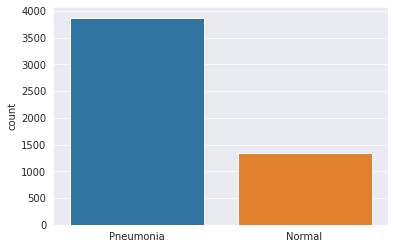

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

훈련 데이터의 비율이 불균형하다는 것을 확인할 수 있습니다. 데이터 불균형은 모델의 과적합으로 이어집니다.  
이를 극복하기 위해 추후 Normal 데이터를 증식하는 작업을 수행할 것입니다.

각 클래스의 이미지 샘플을 살펴봅니다.  
폐렴 환자의 엑스레이 이미지와 정상인의 엑스레이 이미지가 상이함을 확인할 수 있습니다.

Text(0.5, 1.0, 'NORMAL')

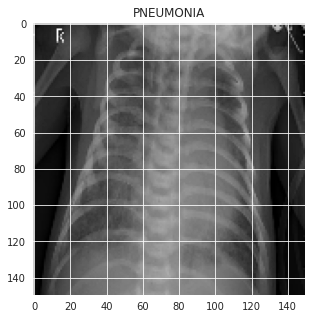

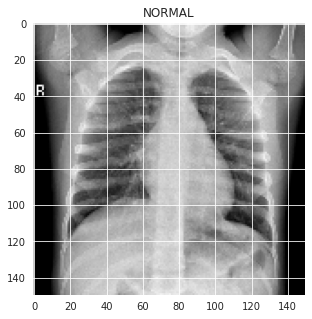

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

## 이미지와 라벨을 각각 x와 y로 나눠줍니다.
- x의 집합은 모델의 입력값이 되며 y의 집합은 모델의 출력값이 됩니다.

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

## 그레이스케일 정규화

- 이미지별 조도의 차이를 줄이고 CNN 모델의 수렴 속도를 증가시키기 위해 greyscale normalization을 수행합니다.
- 노멀라이제이션을 마친 데이터는 0과 1사이의 값을 갖게 됩니다.
- ([0..255] -> [0..1])

x 데이터에 정규화 작업을 수행합니다.

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train[0].shape

(150, 150)

pytorch에서의 딥 러닝 모델 학습을 위해 x 데이터를 reshape합니다.

In [ ]:
x_train = x_train.reshape(-1, 1, img_size, img_size)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, 1, img_size, img_size)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, 1, img_size, img_size)
y_test = np.array(y_test)

In [ ]:
x_train[0].shape

(1, 150, 150)

## 데이터 증식
- 데이터 증식이란 과적합 문제를 피하기 위해 데이터 세트를 인위적으로 확장하는 기술을 뜻합니다.
- 라벨을 동일하게 유지하면서 어레이 표현을 변경하는 방식으로 학습 데이터를 증식할 수 있습니다.
- 자주 쓰이는 이미지 데이터 증식 기법에는 그레이스케일, 수평 플립, 수직 플립, 무작위 크롭, 컬러 변화, 이동, 회전 등이 있습니다.
- 이러한 변환 방법 중 몇 가지를 훈련 데이터에 적용하면 쉽게 훈련 데이터의 수를 늘려 보다 강력한 모델을 만들 수 있습니다.

훈련 데이터는 총 5216개로 구성되어 있습니다.

In [ ]:
len(x_train), len(y_train)

(5216, 5216)

그 중 폐렴에 해당하는 샘플은 3875개이며, 정상에 해당하는 샘플은 1341로 그 차이는 2534개입니다.

In [ ]:
len(x_train[y_train == 0]), len(x_train[y_train == 1]), len(x_train[y_train == 0]) - len(x_train[y_train == 1])

(3875, 1341, 2534)

샘플을 증식하여 데이터 불균형 문제를 어느 정도 해소할 수 있습니다.

적용하려는 증식 기법은 아래 주석과 같습니다.  
torchvision.transforms의 클래스를 조합하여 사용합니다.

In [ ]:
# Randomly rotate some training images by 30 degrees
# Randomly Zoom by 20% some training images
# Randomly shift images horizontally by 10% of the width
# Randomly shift images vertically by 10% of the height
# Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

rotate = transforms.RandomRotation(30, fill=0)
zoom = transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=[1.0, 1.0])
hshift = transforms.RandomAffine(0, translate=[0.1, 0], fill=0)
vshift = transforms.RandomAffine(0, translate=[0, 0.1], fill=0)
hflip = transforms.RandomHorizontalFlip(p=0.5)

transform_pipe = transforms.Compose([
    rotate, zoom, hshift, vshift, hflip
])

transform_lst = [
    rotate, zoom, hshift, vshift, hflip
]

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

원본 데이터와 증식 데이터의 차이를 확인합니다.

original images


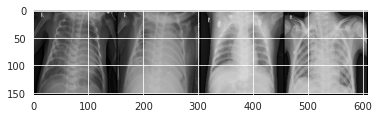


transformed images


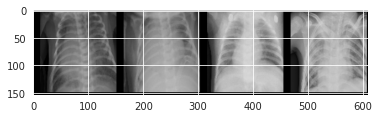

In [ ]:
make_grid = torchvision.utils.make_grid

imgs = torch.Tensor(x_train[:4])
transformed_img = transform_pipe(imgs)

print('original images')
imshow(make_grid(imgs))

print('\ntransformed images')
imshow(make_grid(transformed_img))

정상 샘플만 증식할지 전체 샘플을 모두 증식할지 여부를 결정합니다.

In [ ]:
# 정상 샘플만 증식
targets = x_train[y_train == 1]
labels = y_train[y_train == 1]
difference = len(x_train[y_train == 0]) - len(x_train[y_train == 1])
num_aug = int(difference / 3)

# # 전체 샘플 증식
# targets = x_train
# labels = y_train
# num_aug = len(targets)

증식 기법 활용 방안을 선택한 후 증식 데이터를 생성합니다.

In [ ]:
# select_one이 True일 때는 샘플 당 하나의 증식 기법만 무작위로 선택되어 적용됩니다.
select_one = True

transformed = None
labels4aug = []
for _ in range(num_aug):
    idx = random.randint(0, len(targets) - 1)
    sample = torch.Tensor(targets[idx]).unsqueeze(0)
    
    if select_one:
        aug_idx = random.randint(0, len(transform_lst) - 1)
        transform_pipe = transform_lst[aug_idx]
    
    if type(transformed) == type(None):
        transformed = transform_pipe(sample).numpy()
    else:
        transformed = np.concatenate((transformed, transform_pipe(sample).numpy()), axis=0)
    
    labels4aug.append(labels[idx])
labels4aug = np.array(labels4aug, dtype='int64')

In [ ]:
transformed.shape, labels4aug.shape

((844, 1, 150, 150), (844,))

증식 데이터가 정상적으로 생성되었는지 확인합니다.

transformed images


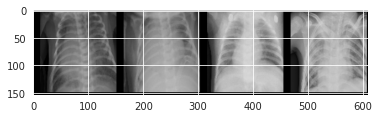

In [ ]:
make_grid = torchvision.utils.make_grid

imgs = torch.Tensor(transformed[:4])

print('transformed images')
imshow(make_grid(transformed_img))

증식 데이터와 원본 데이터 concat 여부를 결정한 뒤 train 데이터의 증식을 마무리합니다.

In [ ]:
# concatenate original and transformed
x_train_augged = np.concatenate((x_train, transformed), axis=0)
y_train_augged = np.concatenate((y_train, labels4aug), axis=0)

# # no concatenation
# x_train_augged = transformed
# y_train_augged = labels4aug

In [ ]:
len(x_train_augged[y_train_augged == 0]), len(x_train_augged[y_train_augged == 1]), len(x_train_augged[y_train_augged == 0]) - len(x_train_augged[y_train_augged == 1])

(3875, 2185, 1690)

## torch.utils.data.Dataset를 상속하는 CustomImageDataset을 선언합니다.
- pytorch 모델은 torch.Tensor 계열의 자료형을 입출력으로 사용합니다.
- CustomImageDataset 클래스에는 샘플의 자료형을 torch.Tensor로 변환해주는 간단한 전처리가 포함되어 있습니다.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return (torch.Tensor(image), torch.Tensor([label]))

In [ ]:
train_set = CustomImageDataset(x_train_augged, y_train_augged)
val_set = CustomImageDataset(x_val, y_val)
test_set = CustomImageDataset(x_test, y_test)

In [ ]:
len(train_set), len(val_set), len(test_set)

(6060, 624, 16)

CustomImageDataset를 통해 샘플이 어떻게 변환되는지 출력해봅니다.

In [ ]:
train_set.__getitem__(0)

(tensor([[[0.0000, 0.0314, 0.0510,  ..., 0.4706, 0.3412, 0.4627],
          [0.0000, 0.0196, 0.0314,  ..., 0.0078, 0.4235, 0.4157],
          [0.0078, 0.0588, 0.0667,  ..., 0.0196, 0.0431, 0.5647],
          ...,
          [0.0314, 0.0275, 0.0157,  ..., 0.0392, 0.0392, 0.0471],
          [0.0314, 0.0275, 0.0118,  ..., 0.0392, 0.0392, 0.0392],
          [0.0314, 0.0275, 0.0157,  ..., 0.0392, 0.0392, 0.0353]]]),
 tensor([0.]))

## 배치의 크기를 선언해주고 훈련 루프마다 미니 배치를 불러올 DataLoader를 생성합니다.

In [ ]:
batch_size = 32

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False, num_workers=1) # num_workers=1 if on single gpu
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1) # num_workers=1 if on single gpu
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1) # num_workers=1 if on single gpu

In [ ]:
len(train_loader), len(val_loader), len(test_loader)

(190, 20, 1)

train_loader의 첫 번째 미니배치를 호출해보면 tensor의 shape이 선언한 배치 크기로 묶여 있음을 확인할 수 있습니다.

In [ ]:
print(next(iter(train_loader))[0].shape)
print(next(iter(train_loader))[1].shape)

torch.Size([32, 1, 150, 150])
torch.Size([32, 1])


미니 배치의 데이터에 이상이 없는지 확인하기 위해 배치에 포함된 이미지를 출력해봅니다.  
32개의 이미지가 모두 정상적으로 출력되는 것을 확인할 수 있습니다.

(3, 610, 1218)


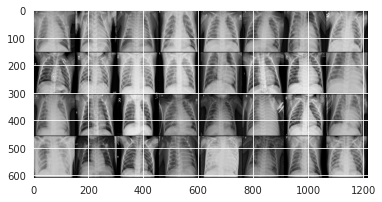

In [ ]:
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
next(dataiter)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# 모델 훈련

## CNN 기반의 BInaryClassifier
- 4층의 Convolutaional 레이어와 2층의 Fully Connected 레이어로 이루어진 BInaryClassifier를 선언합니다.
- Convolutaional 레이어를 거치며 재구축된 image의 representation을 통해 Fully Connected 레이어에서 분류 작업을 수행하는 모델입니다.
- 출력값은 sigmoid 함수를 거쳐 0과 1 사이로 반환됩니다.

In [ ]:
class BInaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, stride=1, padding='same')
        self.conv1_bn = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding='same')
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=1, padding='same')
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, 3, stride=1, padding='same')
        self.conv4_bn = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(256 * 9 * 9, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(self.conv1_bn(self.dropout1(F.relu(self.conv1(x)))))
        x = self.pool(self.conv2_bn(F.relu(self.conv2(x))))
        x = self.pool(self.conv3_bn(self.dropout2(F.relu(self.conv3(x)))))
        x = self.pool(self.conv4_bn(self.dropout2(F.relu(self.conv4(x)))))
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout2(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

선언한 BInaryClassifier 클래스를 통해 model을 생성하고 이후 사용할 하드웨어(cpu 혹은 gpu)로 모델을 옮겨줍니다.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BInaryClassifier().to(device)

모델 학습에 사용될 오차함수와 옵티마이저 LR 스케쥴러를 선언해줍니다.

In [ ]:
learning_rate = 5e-05

In [ ]:
criterion = nn.BCELoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.3, min_lr=1e-6)

훈련을 위한 함수를 정의합니다.

In [ ]:
def train(model, optimizer, criterion, train_loader):
    model.train()
    corrects, total_loss = 0, 0
    size = 0
    for b, batch in enumerate(train_loader):
        x, y = batch
        x, y = x.to(device), y.reshape(-1).to(device)

        optimizer.zero_grad()
        
        logit = model(x).reshape(-1)
        loss = criterion(logit, y)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        prediction = torch.round(logit).long()
        corrects += (prediction.data == y.long().data).sum()

        size += x.shape[0]
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

검증을 위한 함수를 정의합니다.

In [ ]:
def evaluate(model, criterion, val_loader):
    model.eval()
    corrects, total_loss = 0, 0
    size = 0
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.reshape(-1).to(device)

            logit = model(x).reshape(-1)
            loss = criterion(logit, y)

            total_loss += loss.item()

            prediction = torch.round(logit).long()
            corrects += (prediction.data == y.long().data).sum()

            size += x.shape[0]
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

매 에폭마다 걸리는 시간을 계산하기 위한 함수입니다.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

에폭의 수를 선언하고 훈련을 시작합니다.  
에폭마다 val_loss를 기준으로 모델 상태의 저장 여부를 결정합니다.

In [ ]:
n_epochs = 12

In [ ]:
best_val_loss = None
for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, val_loader)
    
    scheduler.step(val_loss)
    cur_lr = scheduler.optimizer.state_dict()['param_groups'][0]['lr']

    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'Learning Rate: {cur_lr}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_accuracy:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_accuracy:.2f}%')
    
    if not best_val_loss or val_loss < best_val_loss:
        torch.save(model.state_dict(), "./binary_classifier_best.pt")
        best_val_loss = val_loss

Epoch: 01 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.359 | Train Acc: 90.96%
	 Val. Loss: 2.476 |  Val. Acc: 38.14%
Epoch: 02 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.832 | Train Acc: 88.30%
	 Val. Loss: 2.402 |  Val. Acc: 43.43%
Epoch: 03 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.611 | Train Acc: 87.87%
	 Val. Loss: 1.479 |  Val. Acc: 47.60%
Epoch: 04 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.564 | Train Acc: 83.22%
	 Val. Loss: 1.462 |  Val. Acc: 43.27%
Epoch: 05 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.316 | Train Acc: 89.04%
	 Val. Loss: 0.771 |  Val. Acc: 70.35%
Epoch: 06 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.260 | Train Acc: 91.44%
	 Val. Loss: 0.543 |  Val. Acc: 80.61%
Epoch: 07 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.183 | Train Acc: 93.35%
	 Val. Loss: 0.536 |  Val. Acc: 82.37%
Epoch: 08 | Epoch Time: 0m 10s
Learning Rate: 5e-05
	Train Loss: 0.138 | Train Acc: 95.30%

모델의 최종 상태를 추가로 저장합니다.

In [ ]:
LAST_PATH = './binary_classifier_last.pt'
torch.save(model.state_dict(), LAST_PATH)

다음과 같이 훈련이 끝난 모델의 상태를 불러올 수 있습니다.  
검증시 손실값을 기준으로 가장 성능이 좋았던 모델을 불러옵니다.

In [ ]:
BEST_PATH = './binary_classifier_best.pt'

model = BInaryClassifier().to(device)
model.load_state_dict(torch.load(BEST_PATH))

<All keys matched successfully>

In [ ]:
test_loss, test_accuracy = evaluate(model, criterion, test_loader)
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_accuracy:.2f}%')

Test Loss: 0.944 |  Test Acc: 68.75%


# 모델의 훈련을 마친 후 성과를 살펴봅니다.

모델의 예측 결과와 본래의 라벨값을 비교하기 위해 훈련을 마친 모델로 추론을 진행합니다.

In [ ]:
predictions = []
targets = []

with torch.no_grad():
    for batch in val_loader:
        x, y = batch
        x, y = x.to(device), y.reshape(-1).to(device)

        logit = model(x).reshape(-1)

        prediction = torch.round(logit).long()
        predictions.append(prediction)

        targets.append(y)

predictions = torch.concat(predictions).cpu().numpy()
targets = torch.concat(targets).cpu().numpy()

혼돈 행렬을 통해 검증 세트에 대한 예측 결과를 살펴봅니다.

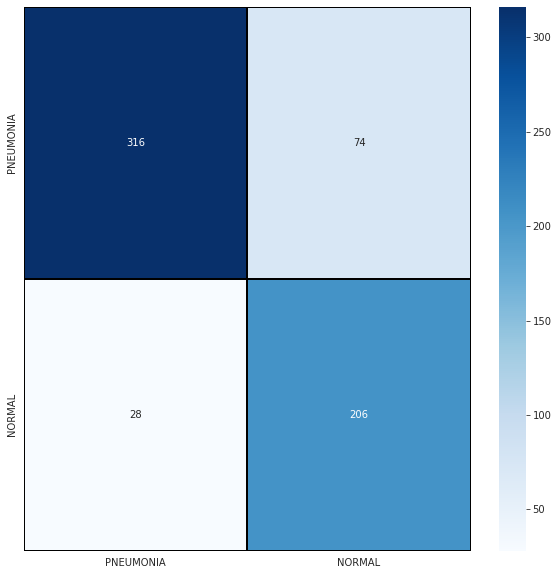

In [ ]:
cm = confusion_matrix(targets, predictions)
cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])

labels = ['PNEUMONIA', 'NORMAL']
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

모델의 예측과 라벨값이 일치하는 경우와 그렇지 않은 경우의 샘플을 추가적으로 살펴봅니다.

In [ ]:
correct = np.nonzero(predictions == targets)[0]
incorrect = np.nonzero(predictions != targets)[0]

예측과 라벨값이 일치하는 경우

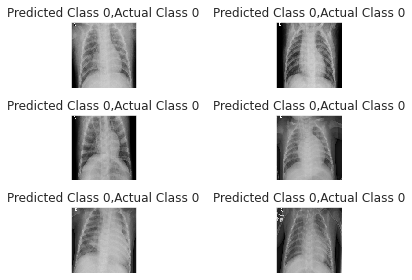

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_val[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_val[c]))
    plt.tight_layout()
    i += 1

예측과 라벨값이 일치하지 않는 경우

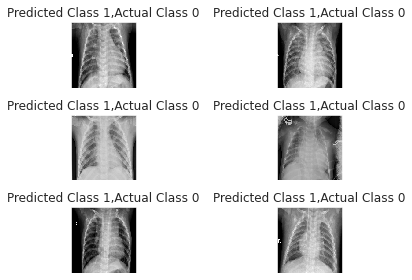

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_val[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_val[c]))
    plt.tight_layout()
    i += 1